In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats

/groups/ahrens/home/zocchid/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
### MLE functions
def partition_list( lst , partition_length , num_partitions):
    partitioned_list = []
    for i in range(num_partitions):
    #in case partition_length does not divide data equally, on the last
    #iteration of the for loop, dump all remaining data into last partition
        if i==num_partitions-1:
            partitioned_list.append( lst[ partition_length * i : ] ) 
        else:
            partitioned_list.append( lst[ partition_length * i : 
                                           partition_length * (i+1) ] )
    return partitioned_list
    
def mix_betas( data , params , weights):
    beta_list = []
    #params is flat list of shape parameters- [a1,b1,a2,b2...]
    #weights is flat list of distribution weights- [w1,w2...]
    for i in range(0 , len(params) , 2):
        beta_list.append( weights[ int( i/2 ) ] * stats.beta.pdf( data,
                                                    params[ i ] , params[ i + 1 ] ,
                                                    loc = 0 , scale = 1 ) )
    
    return np.sum( beta_list , axis = 0) 
    
def neg_log_lik( params , weights , data):
    return -np.sum( np.log( mix_betas( data , params , weights ) ) )

def initial_param_guess(data , num_components):    
    mean = np.mean(data)
    var = np.var(data)
    intermediate = mean * ( 1 - mean ) / var - 1
    alpha = mean * intermediate
    beta = ( 1 - mean ) * intermediate
    return alpha , beta

def update_mix(data , params , weights):
    numer_list = []
    for i in range(0 , len(params) , 2):
        numer_list.append( weights[ int( i/2 ) ] * stats.beta.pdf(data, 
                                                    params[ i ] , params[ i + 1 ] ,
                                                    loc = 0 , scale = 1 ) )
    denom = np.sum( numer_list , axis = 0)    
 
    w_list=[]
    for numer in numer_list:
        r = (numer/denom)
        w_list.append( r.sum() / len(data) )
    return np.array(w_list)

def calc_beta_mean_var(a,b):
    return a/(a+b) , (a*b) / ( (a+b)**2 * (a+b+1) )

def predict_label(data , params , weights):
    numer_list=[]
    for i in range(0 , len(params) , 2):
        numer_list.append( weights[ int( i/2 ) ] * stats.beta.pdf( data , 
                                                      params[i] , params[i+1] , 
                                                      loc = 0 , scale = 1 ) )
    norm = np.sum( numer_list , axis = 0 )

    
    prob_list=[]
    for numer in numer_list:
        prob_list.append( numer / norm)
    return prob_list

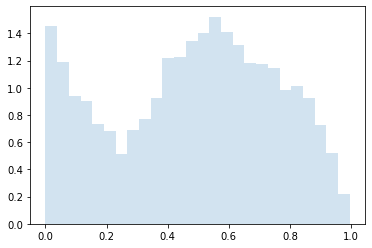

In [12]:
## simulate/load data

simulate = True
data_dir = '/nrs/ahrens/DZ/22-Dec/2p_ablate_analysis/'
data_file = 'main_data_post.txt'


if simulate:
    input_parameters = [1 , 5 , 4 , 2 , 10 , 10]
    input_weights = [0.3 , 0.5 , 0.2]
    num_samples = 10000

    d1 = stats.beta.rvs( input_parameters[0] , input_parameters[1] ,
                        loc = 0 , scale = 1 ,
                        size = int(input_weights[0] * num_samples) , random_state = None )

    d2 = stats.beta.rvs( input_parameters[2] , input_parameters[3] , 
                        loc = 0 , scale = 1 ,
                        size = int(input_weights[1] * num_samples) , random_state = None )

    d3 = stats.beta.rvs( input_parameters[4] , input_parameters[5]  , 
                        loc = 0 , scale = 1 , 
                        size = int(input_weights[2] * num_samples) , random_state = None )

    data=np.concatenate( [ d1 , d2 , d3 ] )
    plt.hist(data,density=True, bins='auto', histtype='stepfilled', alpha=0.2)
else:
    data = np.loadtxt(data_dir + data_file)
    data[np.where(data==0)]=0.001

    for d in data:
        plt.plot(d,0.1,'bx')

    plt.hist(data,density=True, bins='auto', histtype='stepfilled', alpha=0.2)

    print('any 0 values - '+str(np.where(data==0)))

In [13]:
### fit beta mixture model to data

num_components = 3
tolerance = 0.001#1e-10

# sort data, lowest to highest, then partition data into the number 
# of components specified above to feed seperately to generate initial params
sorted_data = np.sort(data)
partition_length = int( len( sorted_data ) / num_components)

partitioned_data = partition_list( sorted_data , partition_length , num_components)

## calculate initial guesses for shape parameters using method of moments
## on each partitioned data set, and set initial weights to equiprobable 
## for each distribution
init_params = []
for part in partitioned_data:
    a , b = initial_param_guess( part , num_components)
    init_params.append( a )
    init_params.append( b )
init_weights = [1/num_components] * num_components
#init_params is a list containing shape params- [alpha1, beta1, alpha2, beta2...]
#init_weights is a list with the corresponding weights- [w1,w2...]


## run first maximization step, store neg log-likelihood value

# hold weights constants, and find shape params that minimize
# the neg log-likelihood function. Args in scipy 'minimize' are 
# passed to the function being minimized and are held
# constant during the minimization
mle_fit=minimize(neg_log_lik , 
                 init_params , args = (init_weights , data ,) ,
                 method = 'NELDER-MEAD', options={'disp': True} )

# run the EM algorithm until change in neg log-likelihood is
# within the tolerance set above
weights = init_weights
neg_ll_hist = [ 0 , mle_fit.fun ]
param_hist = [ mle_fit.x ]
while abs(neg_ll_hist[-1] - neg_ll_hist[-2]) > tolerance:

    #update mixture values using new values of shape params
    params = mle_fit.x
    weights = update_mix(data , params , weights)

    #run next maximization to get new shape params
    mle_fit=minimize(neg_log_lik , 
                 params , args = (weights , data ,) ,
                 method = 'NELDER-MEAD', options={'disp': True} )

    #update history lists
    param_hist.append(mle_fit.x)
    neg_ll_hist.append(mle_fit.fun)

Optimization terminated successfully.
         Current function value: -622.571977
         Iterations: 290
         Function evaluations: 470
Optimization terminated successfully.
         Current function value: -622.962570
         Iterations: 157
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -623.325634
         Iterations: 162
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: -623.660752
         Iterations: 187
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: -623.967842
         Iterations: 173
         Function evaluations: 288
Optimization terminated successfully.
         Current function value: -624.246936
         Iterations: 225
         Function evaluations: 366
Optimization terminated successfully.
         Current function value: -624.498938
         Iterations: 224
         Function evaluations: 355

input params- [1, 5, 4, 2, 10, 10]
fit params- [0.99693717 5.30615701 7.84433613 7.89728983 5.30957287 2.11881458]
input weights- [0.3, 0.5, 0.2]
fit weights- [0.29165327 0.31787017 0.39047655]


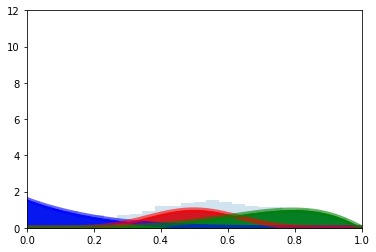

In [14]:
#plot weighted distributions over data histogram

fig, ax = plt.subplots(1, 1)
ax.hist(data,density=True, bins='auto', histtype='stepfilled', alpha=0.2)
x = np.linspace(0,1,1000)
color_list = ['b' , 'r' , 'g']
for i in range(0 , len(params) , 2):
    ax.plot(x, 
            weights[ int( i/2 ) ] * stats.beta.pdf( x, params[ i ] , params[ i + 1 ]),
            color_list[int(i/2)] , lw=5, alpha=0.6, label='beta pdf')
    plt.fill_between(x , 
            weights[ int( i/2 ) ] * stats.beta.pdf( x, params[ i ] , params[ i + 1 ] ) ,
                    color = color_list[int(i/2)])

ax.set_ylim( 0 , 12 )
ax.set_xlim( 0 , 1 )

if simulate:
    print('input params- ' + str(input_parameters))
    print('fit params- ' + str(params))
    print('input weights- ' + str(input_weights))
    print('fit weights- ' + str(weights))
else:
    print('fit params- ' + str(params))
    print('fit weights- ' + str(weights))
#plt.savefig(data_dir+'post_weighted.eps',format='eps')

log likelihood fit = 626.4299321325431
log likelihood original dist = 624.1887288256772


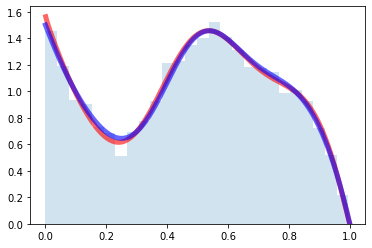

In [15]:
#compare log-likelihoods of fit vs original distribution

print('log likelihood fit = ' + str(-neg_log_lik( params , weights , data ) ) )
print('log likelihood original dist = ' + str(-neg_log_lik( input_parameters , input_weights , data ) ) )

fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)
ax.hist(data,density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.plot(x, mix_betas( x , params , weights ),
       'r-', lw=5, alpha=0.6, label='beta pdf')

ax.plot(x, mix_betas( x , input_parameters , input_weights ),
       'b-', lw=5, alpha=0.6, label='beta pdf')

In [7]:
## assign data points to the component distributions
p_list = predict_label( data, params , weights )


#create a list of lists for the different groupings
header_count = num_components + 1

headers = [[] for i in range(1, header_count)]
prob = np.zeros( [ num_components , data.shape[0] ] )
for i , p in enumerate(p_list):
    prob[ i , : ] = p
    
for i in range(data.shape[0]):

    ret = np.argmax( prob[: , i] )
    #print(ret)
    headers[ ret ].append(data[ i ])
print(headers[0] , headers[1])
#for i in range(num_components):
    
#    np.savetxt(data_dir + 'data_component' + str(i) + '.txt' , headers[i])

[0.1309984392778872, 0.09764899126023296, 0.07186454079768398, 0.059033699616797, 0.03163611249797469, 0.17654262776503057, 0.15462053482544916, 0.2459592385377119, 0.02481269369115931, 0.07964029801817354, 0.03459004260094371, 0.014318591407700244, 0.142823723881589, 0.13372383407643496, 0.22106259423551983, 0.11955986401824163, 0.05906050712633541, 0.2806445531132912, 0.21947208443491098, 0.2491961151471048, 0.06976249835200893, 0.0692946342436351, 0.09414001889633605, 0.2595402414180796, 0.08666390245761897, 0.028591105558277968, 0.03142512112686984, 0.12024983881242539, 0.17050496709075028, 0.1897517167765729, 0.06934023460957056, 0.08888248226133376, 0.09741819433210343, 0.04982124728714415, 0.11860204794464527, 0.08805808061617415, 0.2796149692774421, 0.0993736737073552, 0.09425719496770885, 0.29731575255457576, 0.2780119915078421, 0.2695774336665302, 0.08873245455072229, 0.14926885905986428, 0.0636650775713218, 0.03761744320325174, 0.02530057693686874, 0.3178980693445349, 0.0467